##Twitter Sentiment Analysis
In this notebook we are going to analyze tweets and label them as negative(0), neutral(2) or positive(4).

The dataset is from kaggle and is available [here.](https://https://www.kaggle.com/kazanova/sentiment140)

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import csv

2.3.0


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raziiiuddin","key":"fe8712bcfb41a598e31d26f00318a5a2"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Changing the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# To see a list of popular datasets
#! kaggle datasets list

In [5]:
# The Sentiment140 dataset
! kaggle datasets download -d kazanova/sentiment140

 90% 73.0M/80.9M [00:00<00:00, 95.2MB/s]
100% 80.9M/80.9M [00:00<00:00, 119MB/s] 


In [6]:
import os
import zipfile

local_zip = '/content/sentiment140.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Code to clean the data and remove the LATIN1 encoding

iconv is a command-line program and a standardized api used to convert between different character encodings

In [7]:
!iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

In [9]:
import pandas as pd
data = pd.read_csv("training_cleaned.csv")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
num_sentences = 0
corpus = []
with open('training_cleaned.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        this_item = []
        this_item.append(row[5])
        label = row[0]
        if label == '0':
            this_item.append(0)
        else:
            this_item.append(1)
        num_sentences += 1
        corpus.append(this_item)
        

In [11]:
print(num_sentences)
print(len(corpus))
print(corpus[0])

1600000
1600000
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0]


In [21]:
import random

sentences = []
labels = []
random.shuffle(corpus)

for item in corpus:
    sentences.append(item[0])
    labels.append(item[1])
training_size = 160000
split = 0.9
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

train_split = int(training_size * split)

training_sentences = sentences[0:train_split]
training_labels = labels[0:train_split]
testing_sentences = sentences[train_split:training_size]
testing_labels = labels[train_split:training_size]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)


training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [22]:
print(len(word_index))

128379


In [23]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-10-13 09:39:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 173.194.217.128, 2607:f8b0:400c:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   152MB/s    in 2.2s    

2020-10-13 09:39:40 (152 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           12838000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

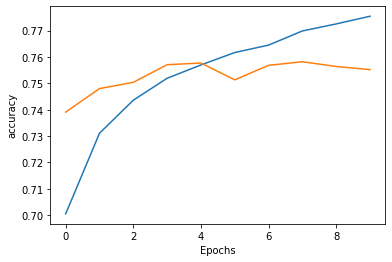

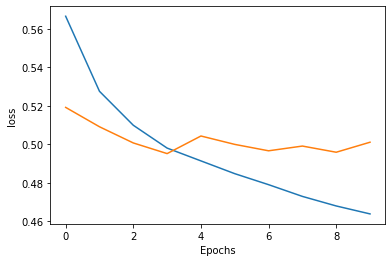

In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

A couple of things to note:

1. I didnot train on the full dataset rather 1/10th of it so you can make changes and try that.

2. Try and train for more epochs.

3. We got a pretty good accuracy.